In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data cropping  

In [113]:
df = pd.read_pickle('../data/data_discretised_200.pkl') 

In [114]:
df

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416,143,142
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609,142,143
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609,142,143
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609,142,143
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609,142,143
...,...,...,...,...,...,...,...,...,...,...,...,...
12827787,851.0,2015,8,7,20,1.0,2015-08-07 20:03:13,26,56.123877,9.849060,200,0
12827788,851.0,2015,8,7,20,2.0,2015-08-07 20:33:14,26,56.123877,9.849060,200,0
12827789,851.0,2015,8,7,21,1.0,2015-08-07 21:03:15,26,56.123877,9.849060,200,0
12827790,851.0,2015,8,7,21,2.0,2015-08-07 21:33:15,26,56.123877,9.849060,200,0


In [115]:
# Create the datetime column without considering 30min_interval
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Add the 30min_interval as a Timedelta
df['date'] += pd.to_timedelta(df['30min_interval'] * 30, unit='m')

In [116]:
df

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin,date
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416,143,142,2013-10-31 12:30:00
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609,142,143,2013-10-31 13:00:00
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609,142,143,2013-10-31 13:30:00
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609,142,143,2013-10-31 14:00:00
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609,142,143,2013-10-31 14:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12827787,851.0,2015,8,7,20,1.0,2015-08-07 20:03:13,26,56.123877,9.849060,200,0,2015-08-07 20:30:00
12827788,851.0,2015,8,7,20,2.0,2015-08-07 20:33:14,26,56.123877,9.849060,200,0,2015-08-07 21:00:00
12827789,851.0,2015,8,7,21,1.0,2015-08-07 21:03:15,26,56.123877,9.849060,200,0,2015-08-07 21:30:00
12827790,851.0,2015,8,7,21,2.0,2015-08-07 21:33:15,26,56.123877,9.849060,200,0,2015-08-07 22:00:00


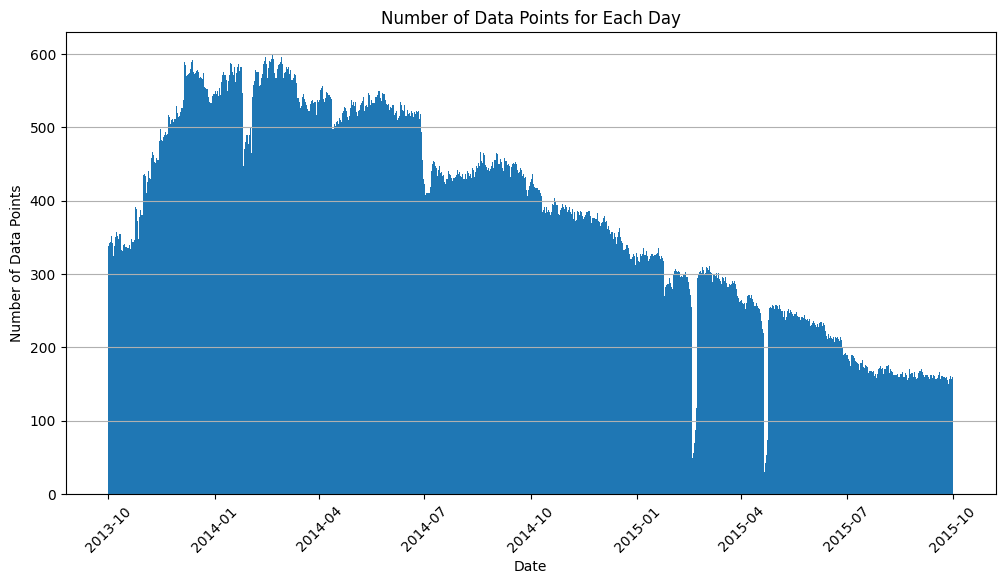

In [117]:
# Group the data by the 'date' column and count the number of data points for each date
date_count = df.groupby('date').size().reset_index(name='count')

# Sort by date for better visualization
date_count = date_count.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(date_count['date'], date_count['count'])
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Day')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add horizontal grid lines

plt.show()

## 1. Select range of data

to exclude low quality data

In [118]:
# remove all rows with date < 2014-01-05 and date > 2014-06-25
df = df[(df['date'] >= '2014-01-05') & (df['date'] <= '2014-06-25')]

We add new column to the data frame called "label" wich has 4 possible labels: "stop", "moving", "outside", or "missing". A row gets the label "stop" if it has a positive integer in the column "stoplocation", "moving" if the column "stoplocation" equals -1, "outside" if one of lan_bin, or lat_bon equals 200

In [119]:
def label_row(row):
    stoplocation = str(row['stoplocation'])  # Convert stoplocation to string to work with its digits
    lat_bin = row['lat_bin']
    lon_bin = row['lon_bin']

    # Check last two digits of 'stoplocation'
    last_two_digits = stoplocation[-2:]
    last_digit = stoplocation[-1:]

    # Label as 'stop'
    if last_two_digits.isnumeric() and int(last_two_digits) > -1:
        return 'stop'
    elif last_digit.isnumeric() and int(last_digit) > 0:
        return 'stop' 
    elif last_two_digits == '_1':
        return 'stop'
    # Label as 'moving'
    elif last_two_digits == '-1':
        return 'moving'
    # Label as 'outside'
    elif lat_bin == 200 or lat_bin == 0 or lon_bin == 200 or lon_bin == 0:
        return 'outside'
    # Label as 'missing'
    else:
        return 'missing'

# Apply the custom function to each row to create the 'label' column
df['label'] = df.apply(label_row, axis=1)


/tmp/ipykernel_252003/601936400.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.apply(label_row, axis=1)


In [120]:
# Adding a new column 'label' based on the conditions
df['label'] = df.apply(lambda row: 
                        'outside' if row['lat_bin'] == 200 or row['lat_bin'] == 0 or row['lon_bin'] == 200 or row['lon_bin'] == 0 else
                        ('stop' if str(row['stoplocation']).split('_')[-1] != '-1' else 
                         ('moving' if str(row['stoplocation']).split('_')[-1] == '-1' else 
                          'missing')),
                        axis=1)

/tmp/ipykernel_252003/582493947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.apply(lambda row:


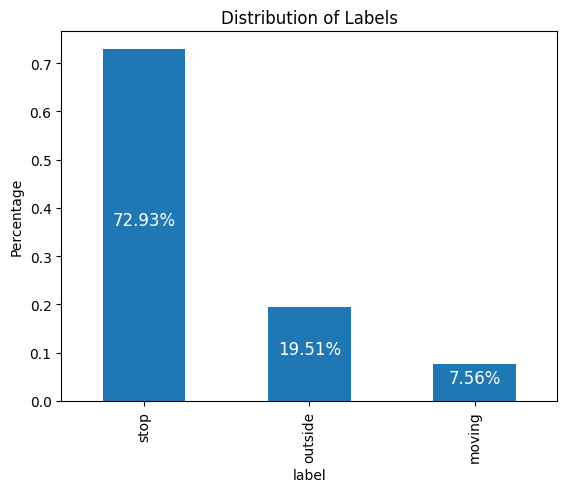

In [121]:
# show the distribution of the labels as bar chart in percentage
df['label'].value_counts(normalize=True).plot(kind='bar')
# add value labels and center the text
for index, value in enumerate(df['label'].value_counts(normalize=True)):
    plt.text(index, value/2, str(round(value*100, 2))+'%', ha='center', color='white', fontsize=12)
plt.title('Distribution of Labels')
plt.ylabel('Percentage')
# save the plot as png image
plt.savefig('../figures/label_distribution.png', bbox_inches='tight', dpi=300)

## 2. Remove data with position outside or moving

In [122]:
# remove all rows with label other than 'stop' 
df = df[df['label'] == 'stop']

In [123]:
df['week_of_year'] = df['date'].dt.isocalendar()['week']


### add user_week as new index

In [124]:
def create_user_week(row):
    # Convert the float 'user' value to an integer
    user_int = int(float(row['user']))
    
    # Convert 'week_of_year' to an integer (it's usually already an integer)
    week_int = int(row['week_of_year'])
    
    # Format both as zero-padded two-digit strings
    user_str = f"{user_int:02d}"
    week_str = f"{week_int:02d}"
    
    # Combine them into a single string with '_w' in between
    return f"u{user_str}_w{week_str}"

df['user_week'] = df.apply(create_user_week, axis=1)

## 3. remove rows with the same position as the previous row

In [125]:
# create a coulumn "pos" with lat_bin and lon_bin as tuple
df['pos'] = df[['lat_bin', 'lon_bin']].apply(tuple, axis=1)
# transform pos column to string
df['pos'] = df['pos'].astype(str)

In [126]:
df.sort_values(by=['user_week', 'date'], inplace=True) #eventually replace user with user_week

# Group by 'user_week' and filter out consecutive duplicates in 'pos'
def filter_consecutive_duplicates(group):
    return group[group['pos'] != group['pos'].shift()]

df = df.groupby('user_week').apply(filter_consecutive_duplicates).reset_index(drop=True)

## 4. remove user weeks with more than 1 day of missing data

In [127]:
# add day of week column
df['day_of_week'] = df['date'].dt.dayofweek

In [128]:
# group df by user_week and count the days for each user_week
user_week_day_count = df.groupby('user_week').agg({'day_of_week': 'nunique'}).reset_index()

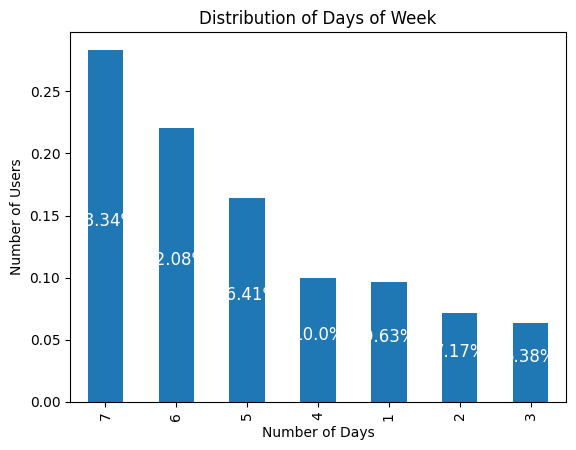

In [129]:
# show the distribution of the days of week as bar chart in percetage
user_week_day_count['day_of_week'].value_counts(normalize=True).plot(kind='bar')
# add labels and center the text
for index, value in enumerate(user_week_day_count['day_of_week'].value_counts(normalize=True)):
    plt.text(index, value/2, str(round(value*100, 2))+'%', ha='center', color='white', fontsize=12)
plt.title('Distribution of Days of Week')
plt.ylabel('Number of Users')
plt.xlabel('Number of Days')
# save the plot as png image
plt.savefig('../figures/days_of_week_distribution.png', bbox_inches='tight', dpi=300)


In [130]:
# remove all user_weeks from df with more than 1 day of missing data
user_week_day_count = user_week_day_count[user_week_day_count['day_of_week'] >= 5]
df = df[df['user_week'].isin(user_week_day_count['user_week'])]

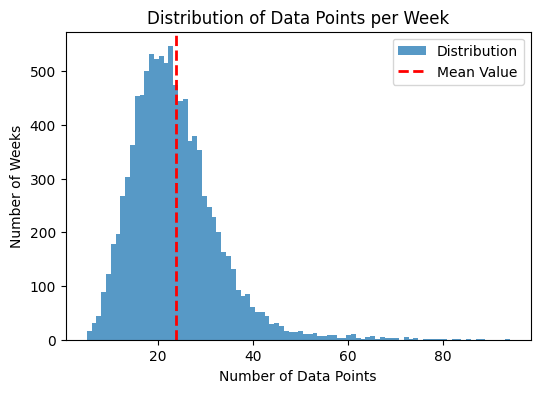

In [141]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Group by user_week and count the number of data points for each user_week
data_points_per_user_week = df.groupby('user_week').size()

# Calculate the mean value of data points per user week
mean_value = data_points_per_user_week.mean()

# set figure size
plt.figure(figsize=(6, 4))

# Plot the distribution of data points per user week
data_points_per_user_week.plot(kind='hist', bins=88, alpha=0.75)


# Add a vertical line for the mean value
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2)



# Add a legend to the plot
plt.legend([ 'Distribution', 'Mean Value'])

# Add labels and title
plt.title('Samples per Week')
plt.xlabel('Number of Data Points')
plt.ylabel('Number of Weeks')

# Save the plot as a PNG image
plt.savefig('../figures/data_points_distribution.png', bbox_inches='tight', dpi=300)


Add rank as new column

In [132]:
# count visits for each user-location pair
visit_counts = df.groupby(['user', 'stoplocation']).size().reset_index(name='visit_count')

# Rank locations for each user based on visit counts
visit_counts['rank'] = visit_counts.groupby('user')['visit_count'].rank(ascending=False, method='min')

# Convert ranks to integers
visit_counts['rank'] = visit_counts['rank'].astype(int)

# Merge this back into the original DataFrame
df = df.merge(visit_counts[['user', 'stoplocation', 'rank']], on=['user', 'stoplocation'])


In [133]:
# save as csv file
df.to_csv('../data/data_all_features_1000.csv')


In [134]:
# # load the data
# import pandas as pd
# df = pd.read_csv('../data/data_all_features.csv', index_col=0)

## 6. remove unnecessary columns

In [135]:
#remove all unnecessary columns: "year", "month", "day", "hour", "30min_interval", "longitude", "latitude", "label", "week_of_year", "day_of_week", timestamp, stoplocation
df = df.drop(columns=[ 'year', 'month', 'day', 'hour', '30min_interval', 'longitude', 'latitude', 'label', 'week_of_year', 'day_of_week', 'timestamp', 'stoplocation','lat_bin', 'lon_bin']) # eventually remove also 'rank'

In [136]:
# save as csv file
df.to_csv('../data/final_data_1000.csv', index=False)